In [1]:
from affogato import seek_data, get_psf, cut, dataPull, errfile, \
                              get_guesses, input_to_guess, make_galfitm_input,\
                              run_galfitm, disp_galfitm, bkp_galfitm

import math
import os
import numpy as np
from astropy.io import fits
from astropy.coordinates import SkyCoord

In [3]:
def automate(working_dir, coord, filters, size, galpath='me',
             imname='galim.png', backupdir=None, bkpname=None,
             customDir=None, customParam=None, customCons=None, useError=False,
             double=False, center_psf=False, **kwargs):
   '''
   This function is my attempt at writing a general-use automatic pipeline of
   the other functions in this wrapper.  It is not exhaustive, and leaves out a
   number of utilities and assumes a default behavior with no options for
   configuration.  For example, disp_galfitm has a large number of customization
   options that are forced here, as does bkp_galfitm. This function is
   implemented identically within affogato and can just be imported, but is
   written out here as an example.

   Parameters
   ----------
   working_dir : str
      Path to working directory where temporary files are stored, relative to
      the current directory.
   
   coord : SkyCoord
      Location of target object.
   
   filters : str
      Filter to pull data for. Currently only works with one filter.
   
   size : int or tuple of ints
      Size, in pixels, of cutout to make around target source. Int implies a
      square cutout.

   galpath : str, optional
      Passed to run_galfitm().  The default is 'me', which uses the path on my
      machine.
   
   imname : str, optional
      Name of output image. The default is 'galim.png'.
   
   backupdir : str, optional
      Directory to store output files. The default is None.
   
   bkpname : str, optional
      Naming convention for output files - gets prepended. The default is None.
   
   customDir : str, optional
      Directory path to find ```customParam``` and ```customCons```. The
      default is None.
   
   customParam : str, optional
      File name to find custom GALFITM parameters rather than deriving them
      analytically. The default is None.
   
   customCons : str, optional
      File name to find custom GALFITM parameters rather than a default. The
      default is None.
   
   useError : bool, optional
      Toggle to use image error map to scale residuals. The default is False.
   
   double : bool, optional
      Adds a central PSF component - otherwise all components are Sersic
      profiles. This is typical for AGN science. The default is False.
   
   center_psf : bool, optional
      Toggle to center the radial profile on the PSF component, if used
      (toggled by ```double```). The default is False.
   
   **kwargs
      Passed to disp_galfitm().

   Returns
   -------
   None.
   '''
   # Match variable names, convert size if needed.
   path = working_dir
   if len(size)>1:
      size = tuple(size)
   else:
      size = tuple(size[0], size[0])
   
   # Download best data at coordinate, and then appropriate PSF
   file = seek_data(coord, working_dir, radius=".02 deg", filters=filters)
   get_psf(file, working_dir, coord)
   
   # Pull appropriate pixel scale from file
   with fits.open(file) as hdul:
      hdu = hdul[1]
      try:
         scale = [hdu.header['CDELT1'], hdu.header['CDELT2']]
      except KeyError:
         cd1 = [hdu.header['CD1_1'], hdu.header['CD1_2']]
         cd2 = [hdu.header['CD2_1'], hdu.header['CD2_2']]
         scale = [((cd1[0])**2 + (cd2[0])**2)**0.5,
                  ((cd1[1])**2 + (cd2[1])**2)**0.5]
         scale = [i*3600 for i in scale] #converts from deg/pix to arcsec/pix
   
   # Cut stamp, and appropriate error stamp if toggled.
   cut(file, coord, size, outputdir=path)
   if useError:
      errfile(file, path)
      cut('%s/errmap.fits' % path, coord, size, outputdir=path,
          outputname='errmap_cut.fits')
      errmap = dataPull('%s/errmap_cut.fits' % path)
   else:
      errmap = None
   
   # Generate quick guesses of parameters for GALFITM, and make param file.
   # Also makes a mask file.
   size, zp, sky, comps = get_guesses(path, double=double, masking=True)
   # overwrite param file with custom file if present
   if customDir is not None:
      custom_param_file = '%s/%s' % (customDir, customParam)
      comps = input_to_guess(custom_param_file)
   
   # Generate GALFITM input and constraint files
   make_galfitm_input(size, zp, scale, sky, comps, outputdir=path)
   # overwrite constraint file with custom constraints if present
   if customCons is not None:
      custom_cons_file = '%s/%s' % (customDir, customCons)
      os.system('cp %s %s/constraints' % (custom_cons_file, working_dir))
   run_galfitm(galpath=galpath, outputdir=path)
   # If using a central PSF, check to center the radial profile on it.
   loc = (-1, -1)
   if double and center_psf:
      comps = input_to_guess(path + '/galfitm.galfit.01')
      psf = next(comp for comp in comps if len(comp) == 3)
      loc = (psf[0], psf[1])
   # Produce output image.
   disp_galfitm(inputdir=path, outputdir=path, save=False, name=imname,
               scale=scale[0], errmap=errmap, loc=loc, **kwargs)
   
   # Back up relevant files.
   if backupdir is not None:
      bkp_galfitm(backupdir, fromdir=path, name=bkpname, gal=True, inpt=False,
                  log=False, image=imname)
   return

<class 'numpy.ndarray'>
Extracted PSF saved to: testing/psf.fits


/Users/ljnolan/opt/anaconda3/envs/affogatwo/lib/python3.11/site-packages/affogato/affogato.py:1601: RuntimeWarning: divide by zero encountered in reciprocal
  fsigma = np.sqrt(data_wht) ** -1
/Users/ljnolan/opt/anaconda3/envs/affogatwo/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:4596: RuntimeWarning: invalid value encountered in scalar subtract
  diff_b_a = b - a



GALFITM Version galfitm-1.4.4
(based on GALFIT Version 3.0.5)


#  Input menu file: input

# IMAGE and GALFIT CONTROL PARAMETERS
A) image.fits          # Input data image (FITS file)
A1) x                  # Band labels
A2) 1.000              # Band wavelengths
B) galfitm.fits        # Output data image block
C) none           0.000   # Sigma image and min. sigma factor (made from data if blank or "none") 
D) psf.fits   #        # Input PSF image and (optional) diffusion kernel
E) 4                   # PSF fine sampling factor relative to data 
F) mask.fits           # Bad pixel mask (FITS image or ASCII coord list)
G) constraints         # File with parameter constraints (ASCII file) 
H) 1    200  1    200  # Image region to fit (xmin xmax ymin ymax)
I) 200    200          # Size of the convolution box (x y)
J) 28.179              # Magnitude photometric zeropoint 
K) 0.120  0.120        # Plate scale (dx dy)   [arcsec per pixel]
O) regular             # Display type (regular, curses

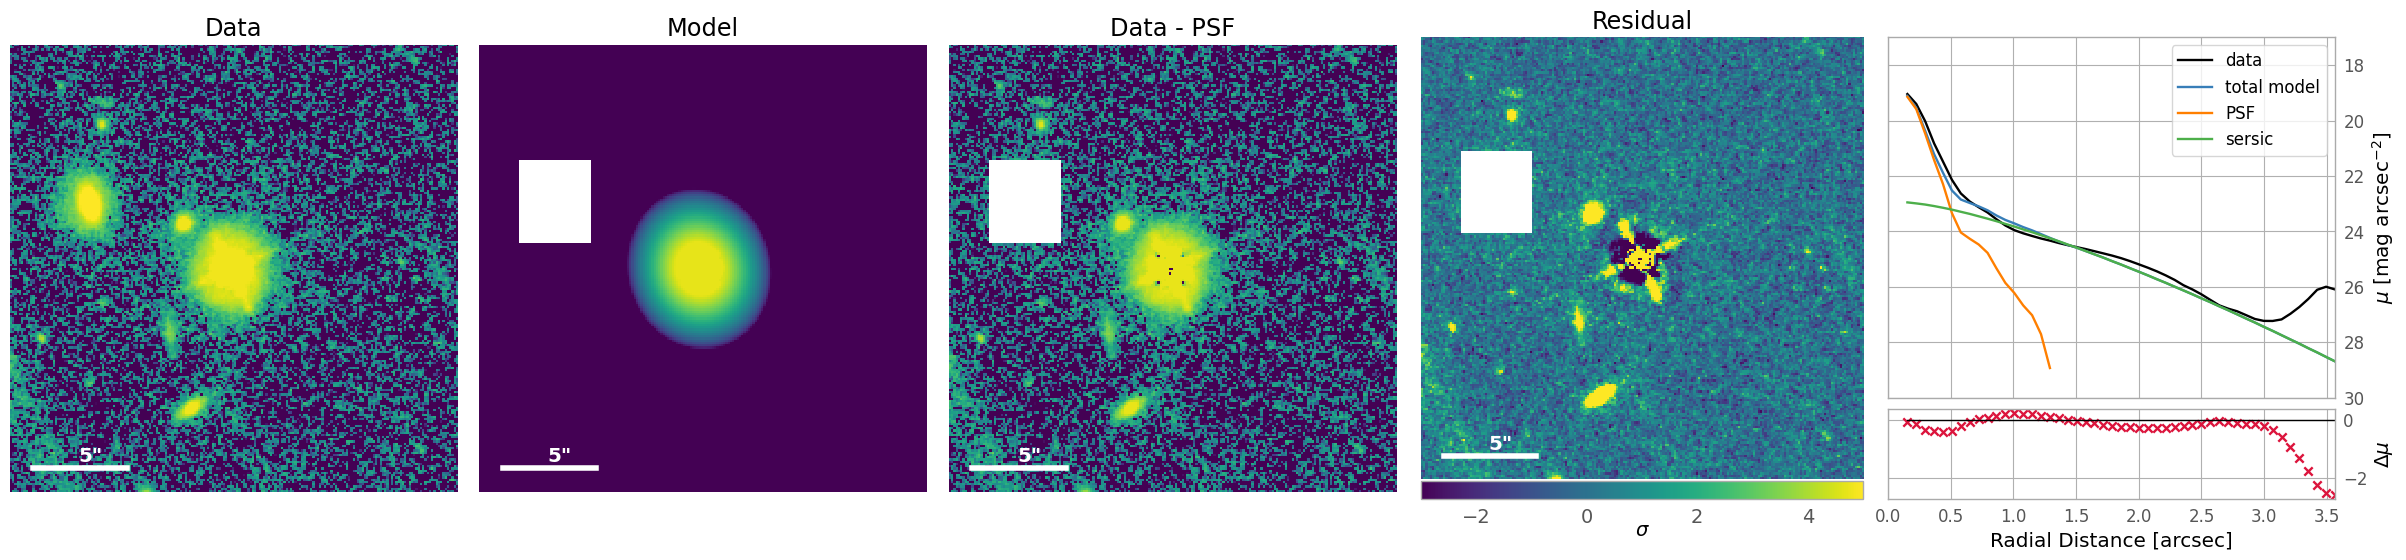

cp: backup/test.galfitm.galfit.01: No such file or directory
cp: backup/test.galfitm.fits: No such file or directory
cp: galim.png: No such file or directory


In [4]:
filters = 'F160W'
working_dir = 'testing' # you will need to create backup/ in this folder, or delete that argument.
size = (200, 200)
coord = SkyCoord(212.5857, 36.723, frame='icrs', unit='deg') # 212.5857, 36.723 is a nice AGN with spiral arms
galpath = 'me' # you will need to change this to where GALFITM is on your machine
file = 'testing/hst_skycell-p2128x19y06_wfc3_ir_f160w_coarse-all_drz.fits'
automate(working_dir, coord, filters, size, backupdir='backup', # if you want backups, create this directory
         bkpname='test', useError=True, double=True, center_psf=True, 
         masking=True, psfsub=True, radprof=True, flx=False, radfrac=0.3)